In [2]:
! /opt/bin/nvidia-smi

Sat May  8 13:56:29 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    24W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# run this cell, then restart the runtime before continuing
!pip install git+https://github.com/huggingface/transformers.git
!pip install nlp

  Cloning https://github.com/huggingface/transformers.git to /tmp/pip-req-build-rgin4k0l
  Running command git clone -q https://github.com/huggingface/transformers.git /tmp/pip-req-build-rgin4k0l
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 3.3MB 13.3MB/s 
     |████████████████████████████████| 901kB 44.7MB/s 
  Created wheel for transformers: filename=transformers-4.6.0.dev0-cp37-none-any.whl size=2213074 sha256=31c57a2f07a6dc93ff7ed73e74e5393888ae18e6bf9a291c8c10f33e884cb1e8
  Stored in directory: /tmp/pip-ephem-wheel-cache-w__n54l6/wheels/33/eb/3b/4bf5dd835e865e472d4fc0754f35ac0edb08fe852e8f21655f
Successfully built transformers
     |████████████████████████████████| 1.7MB 12.7MB/s 
     |████████████████████████████████| 245kB 25.3MB/s 


In [4]:
from transformers import BertForSequenceClassification, BertTokenizerFast, Trainer, TrainingArguments, ReformerConfig, TrainerCallback
from nlp import load_dataset
import torch
import numpy as np
import matplotlib.pyplot as plt

In [5]:
def tokenize(batch):
    return tokenizer(batch['text'], padding=True, truncation=True)

tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
train_dataset, test_dataset = load_dataset('imdb', split=['train', 'test'])
train_dataset = train_dataset.map(tokenize, batched=True, batch_size=len(train_dataset))
test_dataset = test_dataset.map(tokenize, batched=True, batch_size=len(train_dataset))
train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

Dataset imdb downloaded and prepared to /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/76cdbd7249ea3548c928bbf304258dab44d09cd3638d9da8d42480d1d1be3743. Subsequent calls will reuse this data.


In [6]:
separate_q_k_config = ReformerConfig.from_pretrained("bert-base-uncased", lsh_attn_chunk_length=512, local_attn_chunk_length=512, lsh_num_chunks_before=0, local_num_chunks_before=0, attn_layers=["local","local","local","local","local","local","local","local","local","local","local","local"])
separate_q_k_model = BertForSequenceClassification(separate_q_k_config)

separate_steps = []
separate_loss = []
class SeparateLossCallback(TrainerCallback):
    def on_train_end(self, args, state, control, **kwargs):
      log_history = state.log_history
      for index in range(len(log_history) - 1):
        log = log_history[index]
        separate_steps.append(log['step'])
        separate_loss.append(log['loss'])

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=15,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    # evaluation_strategy="steps",
    # eval_steps=200,
    logging_steps=100,
    logging_dir='./logs',
)

separate_q_k_trainer = Trainer(
    model=separate_q_k_model,
    args=training_args,

    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

separate_q_k_trainer.add_callback(SeparateLossCallback())
separate_q_k_trainer.train()

You are using a model of type bert to instantiate a model of type reformer. This is not supported for all configurations of models and can yield errors.


Step,Training Loss
100,0.697900
200,0.714000
300,0.694600
400,0.698600
500,0.599800
600,0.500900
700,0.431000
800,0.428200
900,0.428900
1000,0.403800


TrainOutput(global_step=23445, training_loss=0.11122017879556252, metrics={'train_runtime': 7407.9613, 'train_samples_per_second': 3.165, 'total_flos': 1462870902226944.0, 'epoch': 15.0, 'init_mem_cpu_alloc_delta': 1332944896, 'init_mem_gpu_alloc_delta': 268963328, 'init_mem_cpu_peaked_delta': 0, 'init_mem_gpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': 172048384, 'train_mem_gpu_alloc_delta': 806692352, 'train_mem_cpu_peaked_delta': 174399488, 'train_mem_gpu_peaked_delta': 6695159296})

In [7]:
torch.cuda.empty_cache()

In [8]:
shared_q_k_config = ReformerConfig.from_pretrained("bert-base-uncased", lsh_attn_chunk_length=512, local_attn_chunk_length=512, lsh_num_chunks_before=0, local_num_chunks_before=0, attn_layers=["lsh","lsh","lsh","lsh","lsh","lsh","lsh","lsh","lsh","lsh","lsh","lsh"])
shared_q_k_model = BertForSequenceClassification(shared_q_k_config)

shared_steps = []
shared_loss = []

class SharedLossCallback(TrainerCallback):
    def on_train_end(self, args, state, control, **kwargs):
      log_history = state.log_history
      for index in range(len(log_history) - 1):
        log = log_history[index]
        shared_steps.append(log['step'])
        shared_loss.append(log['loss'])

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=15,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    # evaluation_strategy="steps",
    # eval_steps=200,
    logging_steps=100,
    # evaluate_during_training=True,
    logging_dir='./logs',
)

shared_q_k_model_trainer = Trainer(
    model=shared_q_k_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

shared_q_k_model_trainer.add_callback(SharedLossCallback())
shared_q_k_model_trainer.train()

You are using a model of type bert to instantiate a model of type reformer. This is not supported for all configurations of models and can yield errors.


Step,Training Loss
100,0.701700
200,0.715800
300,0.692800
400,0.707000
500,0.625800
600,0.500600
700,0.434800
800,0.436000
900,0.393700
1000,0.430700


TrainOutput(global_step=23445, training_loss=0.10844635387160016, metrics={'train_runtime': 7381.8689, 'train_samples_per_second': 3.176, 'total_flos': 1462870902226944.0, 'epoch': 15.0, 'init_mem_cpu_alloc_delta': 0, 'init_mem_gpu_alloc_delta': 268439040, 'init_mem_cpu_peaked_delta': 0, 'init_mem_gpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': -249778176, 'train_mem_gpu_alloc_delta': 808265216, 'train_mem_cpu_peaked_delta': 249782272, 'train_mem_gpu_peaked_delta': 6720325120})

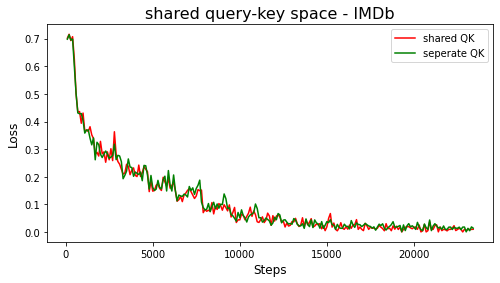

In [9]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(shared_steps, shared_loss, c="r", label="shared QK")
ax.plot(separate_steps, separate_loss, c="g", label="seperate QK")
ax.legend()
ax.set_xlabel("Steps", fontsize=12)
ax.set_ylabel("Loss", fontsize=12)
ax.set_title("shared query-key space - IMDb", fontsize=16)
plt.show()